In [1]:
import numpy as np
import pandas as pd
from bempp_pbs.postprocess import richardson_extrapolation
from matplotlib import pyplot as plt

### Binding Energy calculations using Barnase-Barstar complex (from Fenley's paper)

- *proteins*: 9 Barnase-Barstar complexes (see Table 1)

- *pqr* files:
    - concatenate Barnase and Barstar to get complex pqr

- meshes generated by Nanoshaper:
    - mesh densities: 3, 12, 48 elements per A^2
    
- parameters: 
    - Formulation: derivative exterior
    - regular quadrature: 6
    - FMM p: 10, ncrit:500
    - permittivity: 1 and 80
    - kappa: 0.10265
    
- machine: 1 CPU node on Pegasus

### Fenley's results

Table 1 in their [JCTC paper](https://doi.org/10.1021/ct300765w). Binding free energies of various complexes using different grid spacing.

In [2]:
df_Fenley = pd.read_csv('binding_energy_results/Fenley_results.csv', index_col=0)
Fenley_fine = df_Fenley['0.3A']
df_Fenley

,0.3A,0.4A,0.5A,0.75A,1A
1b27,85.9,86.2,96.7,172.9,273.8
1b2s,72.5,72.0,81.8,145.2,221.7
1b2u,78.9,79.0,87.4,146.2,199.8
1b3s,49.8,49.5,59.0,120.0,223.4
1x1u,75.6,75.8,85.9,167.9,257.8
1x1w,93.7,93.9,106.1,181.6,287.9
1x1x,117.8,118.2,133.5,214.1,309.2
1x1y,88.8,88.9,102.0,187.6,271.7
2za4,75.6,76.1,85.2,135.7,222.5


### Bempp results of solvation energy

- results from using the fine meshes
- results from using Richardson extrapolation

In [3]:
df_solv_coarse = pd.read_csv('binding_energy_results/solvation_energy_coarse.csv', index_col=0)
df_solv_medium = pd.read_csv('binding_energy_results/solvation_energy_medium.csv', index_col=0)
df_solv_fine = pd.read_csv('binding_energy_results/solvation_energy_fine.csv', index_col=0)
df_solv_fine

,complex,barnase,barstar
1b27,-2272.768129,-1278.774107,-1585.071626
1b2s,-2484.582554,-1220.107305,-1629.778746
1b2u,-2403.413104,-1263.128394,-1443.470455
1b3s,-2298.192443,-1299.097240,-1598.992387
1x1u,-2266.107439,-1310.801790,-1585.789476
1x1w,-2082.475340,-1250.460067,-1380.011057
1x1x,-2191.921910,-1293.146143,-1407.786250
1x1y,-2077.034259,-1263.893840,-1321.608398
2za4,-2200.186063,-1197.925436,-1381.231922


In [4]:
components = df_solv_coarse.columns
extrapolated = { col:richardson_extrapolation(df_solv_coarse[col],
                                              df_solv_medium[col],
                                              df_solv_fine[col]) for col in components}
df_solv_extrapolated = pd.DataFrame(extrapolated)
df_solv_extrapolated

,complex,barnase,barstar
1b27,-2264.227056,-1273.837145,-1578.619789
1b2s,-2475.134584,-1215.120832,-1624.398520
1b2u,-2394.334857,-1257.709543,-1438.467537
1b3s,-2289.710693,-1293.886742,-1593.994896
1x1u,-2258.295404,-1305.321454,-1581.149453
1x1w,-2075.604947,-1246.487253,-1374.797558
1x1x,-2185.162428,-1287.619251,-1403.862331
1x1y,-2069.812709,-1259.068838,-1317.295098
2za4,-2191.851903,-1193.064850,-1375.218397


### Coulomb energy

In [5]:
df_coulomb_energy = pd.read_csv('binding_energy_results/coulomb_energy.csv', index_col=0)
coulomb = df_coulomb_energy['diff']

### Compute binding energy

#### binding energy from using the fine mesh

bempp_fine = df_solv_fine.complex - df_solv_fine.barnase - df_solv_fine.barstar + coulomb
pd.concat({'bempp_fine': bempp_fine,
           'Fenley_fine': Fenley_fine,
           'absolute_diff': bempp_fine-Fenley_fine,
           'relative_diff': np.abs((Fenley_fine-bempp_fine)/Fenley_fine)}, axis=1)

#### binding energy from using Richardson extrapolation

In [6]:
bempp_extrapolated = df_solv_extrapolated.complex - df_solv_extrapolated.barnase - df_solv_extrapolated.barstar + coulomb
pd.concat({'bempp_extrapolated': bempp_extrapolated,
           'Fenley_fine': Fenley_fine,
           'absolute_diff': bempp_extrapolated-Fenley_fine,
           'relative_diff': np.abs((Fenley_fine-bempp_extrapolated)/Fenley_fine)}, axis=1)

,bempp_extrapolated,Fenley_fine,absolute_diff,relative_diff
1b27,89.213687,85.9,3.313687,0.038576
1b2s,74.714069,72.5,2.214069,0.030539
1b2u,79.955222,78.9,1.055222,0.013374
1b3s,51.394581,49.8,1.594581,0.032020
1x1u,77.733604,75.6,2.133604,0.028222
1x1w,97.009666,93.7,3.309666,0.035322
1x1x,115.874537,117.8,-1.925463,0.016345
1x1y,90.920613,88.8,2.120613,0.023881
2za4,75.277541,75.6,-0.322459,0.004265


---------

## Compare with MIBPB results ([JCC paper](https://onlinelibrary.wiley.com/doi/10.1002/jcc.24757))

Nguyen and co-workers used MIBPB to compute used the binding energies of the same set of proteins.

Parameters used:
- T = 298K
- dielectric constants: 1 and 80
- ionic strength: 0.1 M NaCl
- linearized PBE solver

Detailed results are from the [supporting information](https://onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1002%2Fjcc.24757&file=jcc24757-sup-0001-suppinfo.pdf) (supplementary materials).

Here we only focus on the Barnase-Barstar set.

### Load Electrostatic solvation free energies computed by MIBPB (Table S1)

We used an [online OCR tool](https://ocr.space/) to obtain the raw results from the PDF.

In [7]:
proteins = df_coulomb_energy.index.values
n_meshes, n_protein, n_components = (10,9,3)
table_s1 = np.loadtxt('binding_energy_results/table_s1.csv').reshape((n_meshes, n_protein, n_components))  # load raw results

The last column in Table S1 corresponds to the results obtained using `0.2 Angstrom`.
Let's extract them into a dataframe.

In [8]:
df_Nguyen_fine_s1 = pd.DataFrame(table_s1[-1], columns=df_solv_extrapolated.columns, index=proteins)
df_Nguyen_fine_s1

,complex,barnase,barstar
1b27,-2263.61,-1272.08,-1578.92
1b2s,-2476.01,-1214.45,-1624.12
1b2u,-2394.69,-1257.74,-1438.00
1b3s,-2289.43,-1294.00,-1592.91
1x1u,-2257.90,-1304.97,-1580.79
1x1w,-2075.25,-1246.32,-1374.09
1x1x,-2184.56,-1287.38,-1403.31
1x1y,-2069.16,-1258.67,-1316.44
2za4,-2191.65,-1192.67,-1375.28


### Load Electrostatic solvation free energies using different solvers (Table S2)

Table S2 spans over multiple pages, so we have 2 raw data files from OCR.

In [9]:
solvers = ['MIBPB', 'DELPHI', 'PBSA', 'APBS']
table_s2_p1 = np.loadtxt('binding_energy_results/table_s2_p1.csv').reshape((len(solvers), 4, n_components))  # load raw results
table_s2_p2 = np.loadtxt('binding_energy_results/table_s2_p2.csv').reshape((len(solvers), 5, n_components))  # load raw results
table_s2 = np.concatenate([table_s2_p1, table_s2_p2], axis=1)

The first column contains results from MIBPB. We extract them into another dataframe.

In [10]:
df_Nguyen_fine_s2 = pd.DataFrame(table_s2[0], columns=df_solv_extrapolated.columns, index=proteins)
df_Nguyen_fine_s2

,complex,barnase,barstar
1b27,-2249.30,-1271.87,-1573.17
1b2s,-2479.25,-1215.08,-1623.42
1b2u,-2395.23,-1260.61,-1431.88
1b3s,-2284.82,-1294.61,-1588.05
1x1u,-2259.77,-1305.77,-1580.44
1x1w,-2074.26,-1250.89,-1372.36
1x1x,-2182.99,-1283.97,-1400.95
1x1y,-2063.87,-1260.57,-1309.84
2za4,-2186.92,-1190.15,-1369.36


> **!!! MIBPB results reported in Table S2 do not match those in S1**

In [11]:
df_Nguyen_fine_s1.values - df_Nguyen_fine_s2.values

array([[-14.31,  -0.21,  -5.75],
       [  3.24,   0.63,  -0.7 ],
       [  0.54,   2.87,  -6.12],
       [ -4.61,   0.61,  -4.86],
       [  1.87,   0.8 ,  -0.35],
       [ -0.99,   4.57,  -1.73],
       [ -1.57,  -3.41,  -2.36],
       [ -5.29,   1.9 ,  -6.6 ],
       [ -4.73,  -2.52,  -5.92]])

### Load Coulomb energies (Table S3)

The Coulomb energies are reported in Table S3.

In [12]:
df_Nguyen_coulomb = pd.read_csv('binding_energy_results/table_s3.csv', index_col=0)
df_Nguyen_coulomb

,energy
1b27,-500.34
1b2s,-290.44
1b2u,-222.48
1b3s,-548.23
1x1u,-551.91
1x1w,-449.86
1x1x,-391.48
1x1y,-416.74
2za4,-301.95


## Load Electrostatic binding free energies computed by MIBPB (Table S4)

In [13]:
table_s4 = np.loadtxt('binding_energy_results/table_s4.csv').reshape((n_meshes, n_protein))  # load raw results

In [14]:
col_names = [ f"{num:1.1f}A" for num in np.linspace(1.1, 0.2, 10) ]
df_Nguyen_binding_energy = pd.DataFrame(table_s4.T, index=proteins, columns=col_names)
df_Nguyen_binding_energy

,1.1A,1.0A,0.9A,0.8A,0.7A,0.6A,0.5A,0.4A,0.3A,0.2A
1b27,86.80,83.08,95.40,82.48,87.05,89.40,87.35,87.96,86.96,87.05
1b2s,67.80,66.33,68.81,71.75,70.03,71.47,72.32,71.93,72.25,72.12
1b2u,85.97,76.39,74.78,78.29,75.29,77.35,77.15,78.38,78.87,78.57
1b3s,48.41,56.58,49.61,46.02,49.87,48.17,53.44,49.38,49.07,49.25
1x1u,61.75,66.86,74.53,75.07,77.56,76.56,75.06,76.41,76.06,75.95
1x1w,90.62,87.91,99.13,93.67,94.65,93.55,95.53,95.32,95.47,95.30
1x1x,115.79,110.40,110.45,112.19,113.51,114.45,115.30,114.65,114.62,114.65
1x1y,67.27,88.13,89.80,90.39,87.87,87.24,88.54,88.91,89.20,89.21
2za4,74.13,70.86,70.64,69.80,72.45,73.22,73.26,74.18,74.00,74.35


Table S4 uses the solvation energies reported from Table S1. The series below agree with the 0.2A column from `df_Nguyen_binding_energy.`

In [15]:
df_Nguyen_fine_s1.complex - df_Nguyen_fine_s1.barnase - df_Nguyen_fine_s1.barstar + df_Nguyen_coulomb.energy

1b27     87.05
1b2s     72.12
1b2u     78.57
1b3s     49.25
1x1u     75.95
1x1w     95.30
1x1x    114.65
1x1y     89.21
2za4     74.35
dtype: float64

In [16]:
df_Nguyen_fine_s2.complex - df_Nguyen_fine_s2.barnase - df_Nguyen_fine_s2.barstar + df_Nguyen_coulomb.energy

1b27     95.40
1b2s     68.81
1b2u     74.78
1b3s     49.61
1x1u     74.53
1x1w     99.13
1x1x    110.45
1x1y     89.80
2za4     70.64
dtype: float64

## Compare Bempp's results with numbers in Table S2

In [17]:
table_s2_reshape = np.moveaxis(table_s2, 0, -1).reshape(n_protein*n_components, len(solvers))
multi_index = pd.MultiIndex.from_product([proteins, components])
df_solv_compare = pd.DataFrame(table_s2_reshape, index=multi_index, columns=solvers)
df_solv_compare['Bempp_extrapolated'] = df_solv_extrapolated.values.flatten()
df_solv_compare['Bempp'] = df_solv_fine.values.flatten()

In [18]:
df_solv_compare

MIBPB   DELPHI     PBSA     APBS  Bempp_extrapolated  \
1b27 complex -2249.30 -2275.06 -2276.57 -2278.35        -2264.227056   
     barnase -1271.87 -1280.83 -1281.19 -1287.49        -1273.837145   
     barstar -1573.17 -1582.44 -1583.82 -1596.87        -1578.619789   
1b2s complex -2479.25 -2484.09 -2484.95 -2486.63        -2475.134584   
     barnase -1215.08 -1222.80 -1223.51 -1228.05        -1215.120832   
     barstar -1623.42 -1628.13 -1628.40 -1642.15        -1624.398520   
1b2u complex -2395.23 -2402.37 -2404.43 -2401.67        -2394.334857   
     barnase -1260.61 -1266.62 -1267.33 -1272.83        -1257.709543   
     barstar -1431.88 -1442.60 -1443.80 -1454.69        -1438.467537   
1b3s complex -2284.82 -2301.11 -2301.66 -2299.54        -2289.710693   
     barnase -1294.61 -1302.15 -1302.36 -1310.05        -1293.886742   
     barstar -1588.05 -1596.40 -1597.15 -1609.29        -1593.994896   
1x1u complex -2259.77 -2266.17 -2267.15 -2264.06        -2258.295404   
     barnase -1305.77 -1313.40 -1313.73 -1320.38        -1305.321454   
     barstar -1580.44 -1583.60 -1585.08 -1594.35        -1581.149453   
1x1w complex -2074.26 -2085.57 -2086.04 -2085.77        -2075.604947   
     barnase -1250.89 -1254.77 -1254.68 -1261.68        -1246.487253   
     barstar -1372.36 -1378.75 -1378.96 -1388.03        -1374.797558   
1x1x complex -2182.99 -2194.52 -2196.08 -2196.55        -2185.162428   
     barnase -1283.97 -1296.22 -1296.70 -1304.99        -1287.619251   
     barstar -1400.95 -1407.82 -1408.62 -1416.62        -1403.862331   
1x1y complex -2063.87 -2072.54 -2073.11 -2076.32        -2069.812709   
     barnase -1260.57 -1266.62 -1266.95 -1273.64        -1259.068838   
     barstar -1309.84 -1321.10 -1321.69 -1331.25        -1317.295098   
2za4 complex -2186.92 -2199.85 -2201.20 -2190.73        -2191.851903   
     barnase -1190.15 -1200.30 -1201.53 -1207.18        -1193.064850   
     barstar -1369.36 -1380.38 -1381.52 -1393.47        -1375.218397   

                    Bempp  
1b27 complex -2272.768129  
     barnase -1278.774107  
     barstar -1585.071626  
1b2s complex -2484.582554  
     barnase -1220.107305  
     barstar -1629.778746  
1b2u complex -2403.413104  
     barnase -1263.128394  
     barstar -1443.470455  
1b3s complex -2298.192443  
     barnase -1299.097240  
     barstar -1598.992387  
1x1u complex -2266.107439  
     barnase -1310.801790  
     barstar -1585.789476  
1x1w complex -2082.475340  
     barnase -1250.460067  
     barstar -1380.011057  
1x1x complex -2191.921910  
     barnase -1293.146143  
     barstar -1407.786250  
1x1y complex -2077.034259  
     barnase -1263.893840  
     barstar -1321.608398  
2za4 complex -2200.186063  
     barnase -1197.925436  
     barstar -1381.231922

## Compare binding energies

We used Bempp fine results in this comparison.

In [19]:
solv_diff = df_solv_compare.values[::3] - df_solv_compare.values[1::3] - df_solv_compare.values[2::3]
binding_energy = solv_diff + coulomb.values.reshape((-1,1))

In [20]:
df_binding_energy = pd.DataFrame(binding_energy, index=proteins, columns=df_solv_compare.columns)
df_binding_energy['ACG'] = Fenley_fine
df_binding_energy

,MIBPB,DELPHI,PBSA,APBS,Bempp_extrapolated,Bempp,ACG
1b27,96.723808,89.193808,89.423808,106.993808,89.213687,92.061412,85.9
1b2s,69.579302,77.169302,77.289302,93.899302,74.714069,75.632798,72.5
1b2u,75.372999,84.962999,84.812999,103.962999,79.955222,81.298744,78.9
1b3s,51.063636,50.663636,51.073636,73.023636,51.394581,53.120820,49.8
1x1u,75.998101,80.388101,81.218101,100.228101,77.733604,80.041927,75.6
1x1w,100.319802,99.279802,98.929802,115.269802,97.009666,99.325585,93.7
1x1x,111.485383,119.075383,118.795383,134.615383,115.874537,118.565867,117.8
1x1y,90.909386,99.549386,99.899386,112.939386,90.920613,92.837366,88.8
2za4,71.436198,79.676198,80.696198,108.766198,75.277541,77.817493,75.6


In [21]:
del df_binding_energy['Bempp_extrapolated']
del df_solv_compare['Bempp_extrapolated']

In [22]:
# df_binding_energy.to_csv('binding_energy_comparison.csv', float_format='%.1f')
# df_solv_compare.to_csv('solv_energy_comparison.csv', float_format='%.1f')

### Binding energy scatter plot

In [23]:
plt.rcParams["font.family"] = "serif"

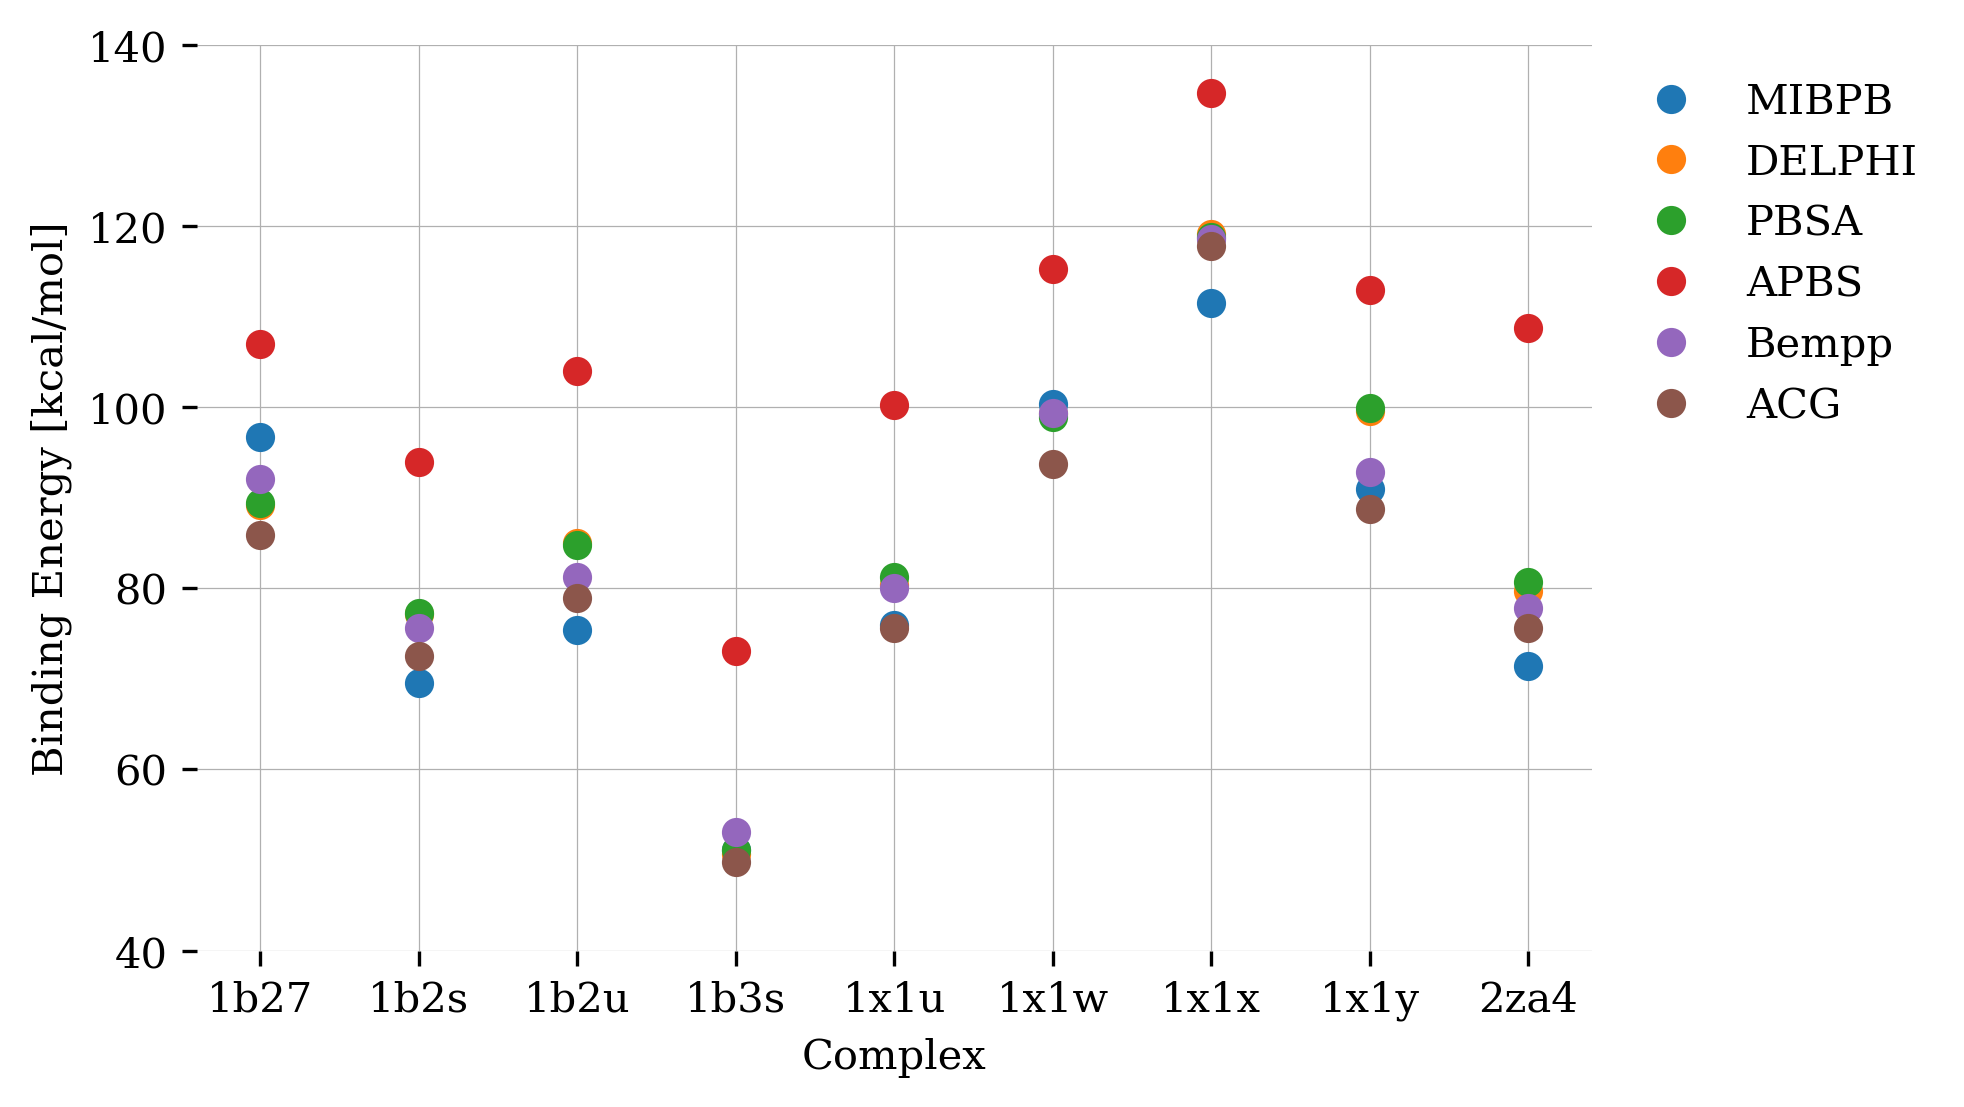

In [24]:
f, (ax) = plt.subplots(1, figsize=(6,4), dpi=300)
df_binding_energy.plot(ax=ax, ls='', marker='o')
plt.ylabel("Binding Energy [kcal/mol]")
plt.xlabel("Complex")
legend = plt.legend(bbox_to_anchor=(1, 1), frameon=False);
plt.box(False);
plt.ylim(40,140)
plt.grid(linewidth=0.3);
# plt.savefig('../../tex/figs/binding_energy.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight');

### Solvation energy scatter plot (complex only)

In [25]:
df_solv_compare_complex = df_solv_compare.xs('complex', level=1, drop_level=True)

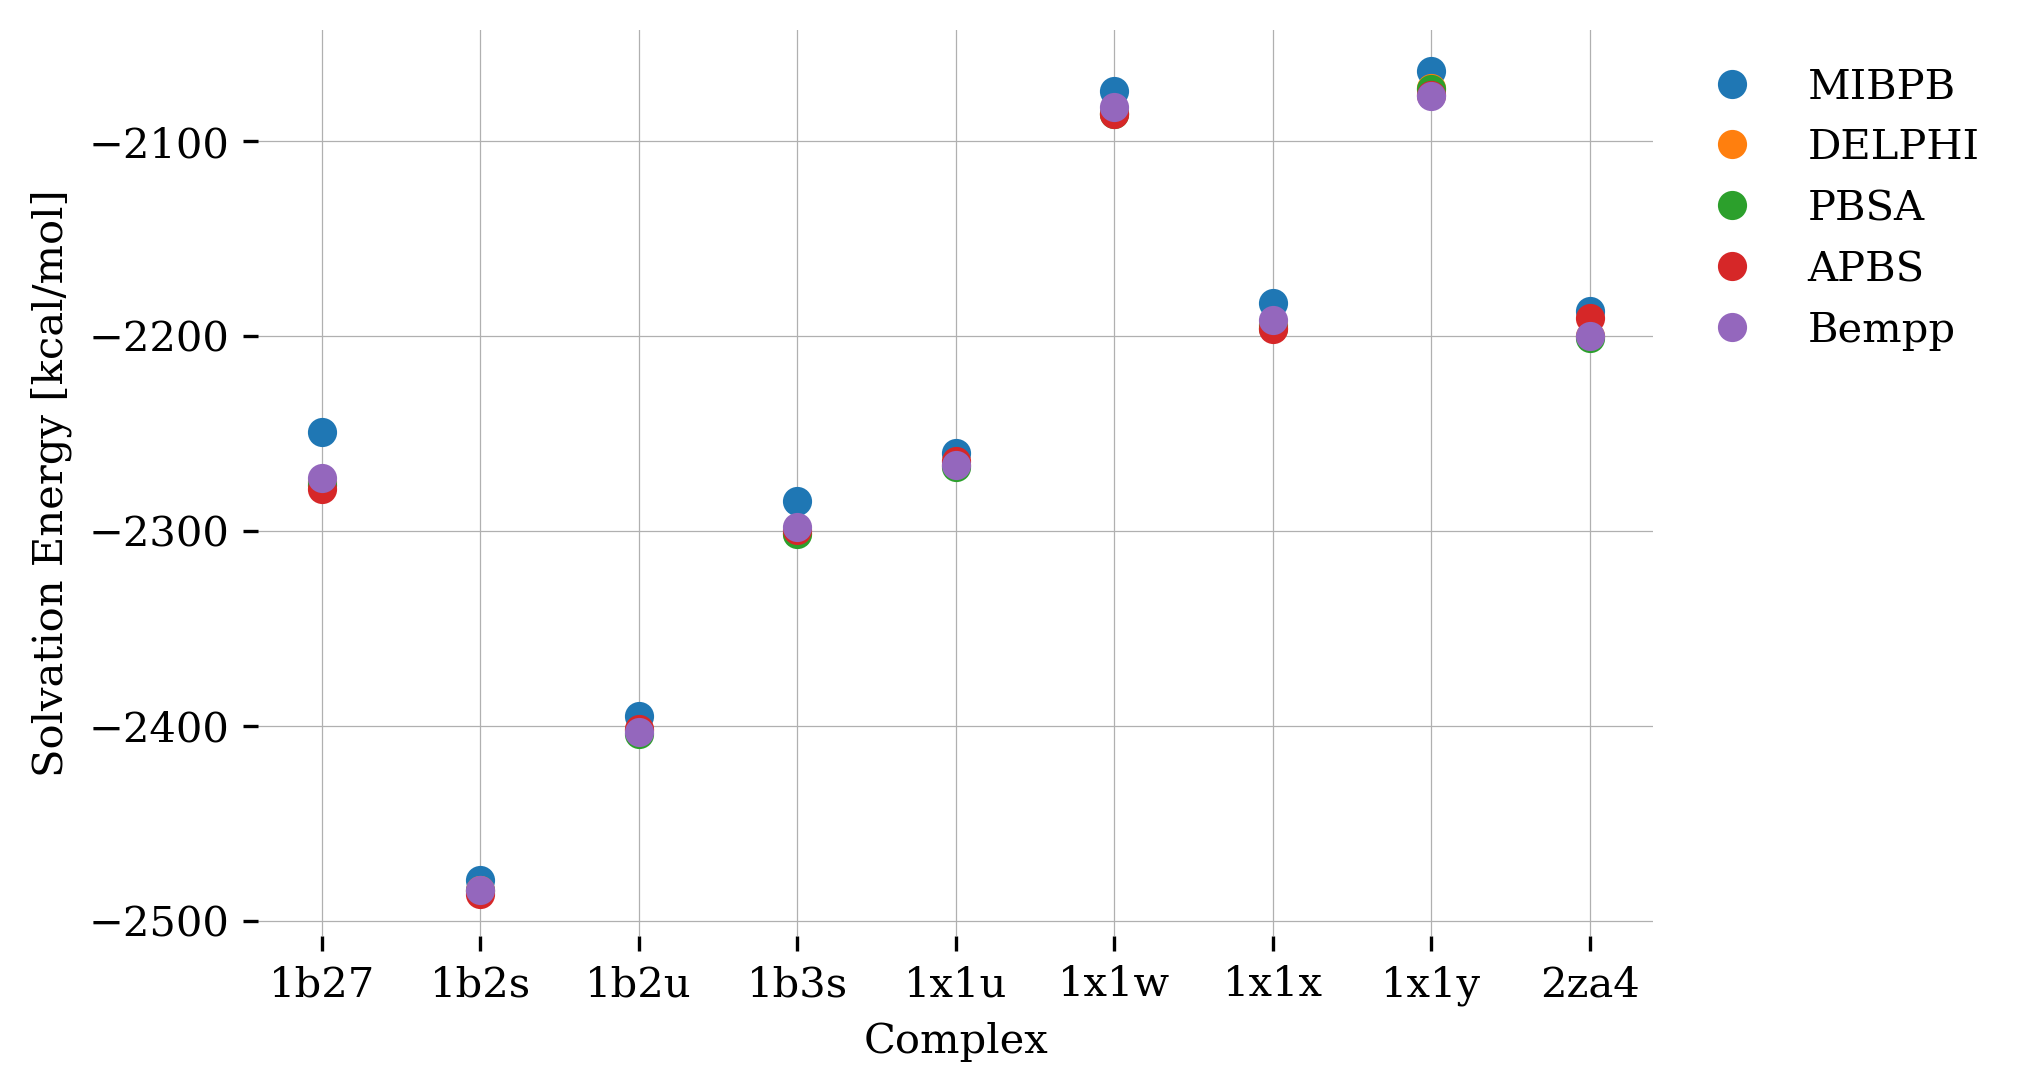

In [26]:
f, (ax) = plt.subplots(1, figsize=(6,4), dpi=300)
df_solv_compare_complex.plot(ax=ax, ls='', marker='o')
plt.ylabel("Solvation Energy [kcal/mol]")
plt.xlabel("Complex")
legend = plt.legend(bbox_to_anchor=(1, 1), frameon=False);
plt.box(False);
#plt.ylim(40,140)
plt.grid(linewidth=0.3);
# plt.savefig('../../tex/figs/solvation_energy_complex.pdf', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight');